In this notebook, I perform Monte Carlo simulations and permutations tests to determine whether the temporal concentration that we observe in the stations is statistically significant.

# Staging

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
import random as rd
from numpy import random
import warnings

In [2]:
# Import station code and name mapper
df_stn = pd.read_csv('outputs/stn_data/others/stn_code_name.csv')

# Remove the three stations omitted in this study
stn_omit = ['Battersea Power Station', 'Heathrow Terminal 4 LU', 'Nine Elms']
df_stn = df_stn[~df_stn['stn_name'].isin(stn_omit)]

# List of unique station names
stn_name = sorted(list(set(df_stn['stn_name'])))

In [3]:
# Import operating hours mapper
df_time = pd.read_csv('outputs/stn_data/others/operating_hours.csv')

# Labels of slots
slots = ['slot_'+str(i) for i in df_time['timeslot']]
slots_plot = df_time['entrytime_start']

# Set of slots and number of slots
slots_set = set(df_time['timeslot'])
n_slots = len(slots_set)

In [4]:
# Time series data
stn_ts_throughput = pd.read_csv('outputs/stn_data/demand/stn_ts_throughput.csv',
                                index_col='StationName')

# Concentration data
stn_conc_throughput = pd.read_csv('outputs/stn_data/concentration/stn_conc_throughput.csv')

In [5]:
h = 6
wt_mtd = 'indicator'

In [6]:
# Threshold p-value
p_threshold = 0.05

In [7]:
sns.set(style="darkgrid")

In [8]:
# Set color palette
col_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Functions for Scalability

In [9]:
# Create function to generate equation to tune alpha

def func(x, wt_list, wt_sum):

    '''
    Generate the callable equation to tune alpha for either
    simple exponential smoohting or negative power weighting method
    using fsolve function in scipy.

    :param x: variable for alpha
    :param wt_list: list of weights
    :param wt_sum: sum of weights
    :return: Callable function
    '''

    # Generate eqn
    eqn = ' + '.join(wt_list) + wt_sum

    return eval(eqn)

In [10]:
# Create function to generate temporal weight matrix

def temporal_wt_matrix(df, n_nb, wt_mtd):

    '''
    Compute the temporal weight matrix for a time series,
    based on the number of neighbours and weight assignment method
    chosen by user.

    :param df: the time series data
    :param n_nb: number of neighbours
    :param wt_mth: method to assigning weights; ['indicator', 'ses', 'neg_pow' or 'neg_exp']
    :return: list of temporally lagged values
    '''

    # Need to import math here again because of 
    # issues with using 'eval' in local scope
    import math

    # Initialize dataframe to hold temporal weight matrix
    wt_matrix = {}

    # Get length of time series,
    # check whether length is odd or even, 
    # and get midpoint
    T = len(df)
    odd_even = T%2   # odd if 1, even if 0
    if odd_even == 1:
        midpoint = math.ceil(T/2)
    else:
        midpoint = math.floor(T/2)

    # Get slot names
    slot_idx = df.index

    # Set sum of weights and del_t
    if wt_mtd == 'indicator':
        wt_sum = -1
        del_t = None
    if wt_mtd == 'ses':
        wt_sum = -0.999
        del_t = None
    if wt_mtd == 'neg_pow' or wt_mtd == 'neg_exp':
        wt_sum = -1
        del_t = 15

    # Solve for value of alpha first
    if wt_mtd == 'indicator':
        base_eqn = ['x' for j in range(T)]
    if wt_mtd == 'ses':
        base_eqn = ['x*(1-x)**'+str(j) for j in range(T)]
    if wt_mtd == 'neg_pow':
        base_eqn = ['(' + str(j+1) + '*' + str(del_t) + ')**(-x)'
                    for j in range(T)]
    if wt_mtd == 'neg_exp':
        base_eqn = ['math.exp(-x*' + str(j+1) + '*' + str(del_t) + ')'
                    for j in range(T)]

    x = fsolve(func, [wt_sum/T],
               args=(base_eqn, str(wt_sum)))[0]

    # For observations of interest i up to mid-point
    for i in range(1, midpoint+1):

        # Get number of weights on the right
        last_wt = min(n_nb, T-i)

        # Generate right half of weights
        if wt_mtd == 'indicator':
            right_wt = ['x' for j in range(last_wt)]
        if wt_mtd == 'ses':
            right_wt = ['x*(1-x)**'+str(j) for j in range(last_wt)]
        if wt_mtd == 'neg_pow':
            right_wt = ['(' + str(j+1) + '*' + str(del_t) + ')**(-x)'
                        for j in range(last_wt)]
        if wt_mtd == 'neg_exp':
            right_wt = ['math.exp(-x*' + str(j+1) + '*' + str(del_t) + ')'
                        for j in range(last_wt)]

        # Add trailing zeros in right half of weight list
        right_wt = right_wt + ['0']*(T-i-n_nb)

        # Generate entire weight list
        wt_matrix[slot_idx[i-1]] = right_wt[0:i-1][::-1] + ['0'] + right_wt

    # Compute weights
    scope = locals()
    for k, v in wt_matrix.items():
        wt_list = [eval(j, scope) for j in v]
        if n_nb != 0:
            wt_matrix[k] = [j/sum(wt_list) for j in wt_list]
        else:
            wt_matrix[k] = wt_list

    # For remaining observations of interest i
    for i in range(midpoint+1, T+1):
        # Get 'index' of mirror observation
        mirror = (T-i)+1
        wt_matrix[slot_idx[i-1]] = wt_matrix[slot_idx[mirror-1]][::-1]

    return wt_matrix

In [11]:
# Create function to compute temporally lagged values

def temporal_lagged(df, wt_matrix):

    '''
    Compute the temporally lagged values for a time series.

    :param df: the time series data
    :param wt_matrix: dictionary of weight matrix
    :return: list of temporally lagged values
    '''

    # Compute temporally lagged variable
    temp_lagged = [sum(df['Y']*wt_matrix[slot]) for slot in df.index]

    return temp_lagged

In [12]:
# Create function to compute Gini

def gini(df, var_type):

    '''
    Compute the Gini index for the entries. 
    Works for both original time series data and temporally lagged data

    :param df: the time series data
    :param var_type: whether it is for original values or temporally lagged values, ['Y', 'WY']
    :return: Gini index
    '''

    # Sort time slot in ascending order by value
    df_sorted = df.sort_values(var_type)

    # Add a column on the cumulative distribution function of rank, F
    n_slots = len(df_sorted)
    df_sorted['F'] = np.array(range(1, n_slots+1)) / n_slots

    # Compute Gini index
    covar = df_sorted.cov().loc['Y', 'F']
    gini_stn = 2*covar/df_sorted['Y'].mean()

    return gini_stn

In [13]:
# Create function to compute p-value from simulation results

def compute_p(sim_val, test_stat):

    '''
    Compute the p-values from simulation results.
    P-values are one-tailed, where test stat is greater than observed

    :param sim_val: simulation values
    :param test_stat: observed test statistics
    :return p_val: p-value
    :return rt: number of values greater than test statistics
    '''

    # Convert simulation values to array
    sim_val_array = np.array(sim_val)
    
    # Get number of values greater than test statistics
    rt = sum(sim_val_array > test_stat)
    
    # Compute p-value
    p_val = (rt+1)/(len(sim_val)+1)

    return p_val, rt

# Monte Carlo Simulation to Test Gini

I will now perform Monte Carlo simulation to determine whether the temporal concentration of journeys is significantly higher than expected. To perform the simulation, for each of the stations, I first find the the total number of demand in a day. I then use a uniform distribution to determine when each demand occurs.

## Functions for Scalability

In [14]:
# Create function to perform one run of Monte Carlo simulation

def mc_gini(df_ts, df_conc, n_sim):

    '''
    Perform one run of Monte Carlo simulation to compute p-value for Gini
    
    :param df_ts: the df of time series data
    :param df_conc: the df of concentration data
    :param n_sim: number of simulations in a run
    :return df_sim: df of stations and Gini for each simulation
    :return df_p: df of stations and their p-value
    '''

    # Columns headers
    col_head = ['sim_' + str(n) for n in range(n_sim)]

    # Create list to hold p-value
    p_list = []

    # Get station names
    stn_names = df_conc['StationName']

    # Get number of slots
    n_slot = len(df_ts.columns)

    # For each station
    for stn in stn_names:

        # Get actual Gini of stn
        G = df_conc.loc[df_conc['StationName'] == stn, 'gini'].values[0]

        # Create list to hold Gini values from bootstrap
        G_bs = []

        # Find total demand
        tot_demand = math.ceil(sum(df_ts.loc[stn, :]))

        # Compute Gini
        for n in range(n_sim):

            # Generate when demand occurs
            rand_slot = rd.choices(range(1, n_slot+1), k=tot_demand)

            # Count values
            values, counts = np.unique(rand_slot, return_counts=True)

            # Find timeslots with no demand and add back
            slot_null = set(range(1, n_slots+1))-set(values)
            values = list(values) + list(slot_null)
            counts = list(counts) + [0]*len(slot_null)

            # Compute Gini
            Y = pd.DataFrame(counts, columns=['Y'])
            G_bs.append(gini(Y, 'Y'))

        # Create/append dataframe to hold simulation results
        df_temp = pd.DataFrame([G_bs], columns=col_head, index=[stn])
        if stn == stn_names[0]:
            df_sim = df_temp.copy()
        else:
            df_sim = pd.concat([df_sim, df_temp])

        # Compute p-value
        p, _ = compute_p(G_bs, G)
        p_list.append(p)

    # Create dataframe of bounds
    df_p = pd.DataFrame(zip(stn_names, p_list),
                        columns=['StationName', 'p-value'])

    return df_sim, df_p

## Run Simulations

In [15]:
# Set up parameters
n_sim_mc = 500
n_run_mc = 20
offset_mc = 0

In [16]:
# Note: All the simulation results reported in the dissertation have been uploaded on the output folders

# Run simulations for entries
for run in range(offset_mc, n_run_mc+offset_mc):

    print(f'Run {run}')
    #df_sim_run, df_p_run = mc_gini(df_ts=stn_ts_throughput,
    #                               df_conc=stn_conc_throughput,
    #                               n_sim=n_sim_mc)
    #df_sim_run.to_csv('outputs/sig_test/mc_gini/sim_'+str(run)+'.csv')
    #df_p_run.to_csv('outputs/sig_test/mc_gini/p_'+str(run)+'.csv', index=False)
    
print('Done!')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Done!


## Inspect Simulation Results

In [17]:
# Retrieve all Gini values from simulations
for run in range(n_run_mc):
    df_temp = pd.read_csv('outputs/sig_test/mc_gini/sim_'+str(run)+'.csv')
    df_temp.rename(columns={'Unnamed: 0': 'StationName'}, inplace=True)
    df_temp.set_index('StationName', inplace=True)
    if run == 0:
        df_sim = df_temp.copy()
    else:
        df_sim = pd.concat([df_sim, df_temp], axis=1)

In [18]:
# Compute p-value for stations
p_list = []
rt_list = []

# For each station
for stn in stn_name:
    # Get observed Gini value
    stn_gini = stn_conc_throughput.loc[stn_conc_throughput['StationName'] == stn,'gini'].values[0]
    # Compute p-value
    p, rt = compute_p(df_sim.loc[stn, :].tolist(), stn_gini)
    p_list.append(p)
    rt_list.append(rt)

# Create dataframe
p_gini = pd.DataFrame(zip(stn_name, p_list, rt_list), columns=['StationName', 'p_value', 'rt'])

# Merge gini data
p_gini = p_gini.merge(stn_conc_throughput[['StationName', 'gini']], on='StationName')

In [19]:
# Rank stations by their p-value
p_gini.sort_values(by=['p_value', 'rt', 'gini'],
                   ascending=[False, False, True], inplace=True)

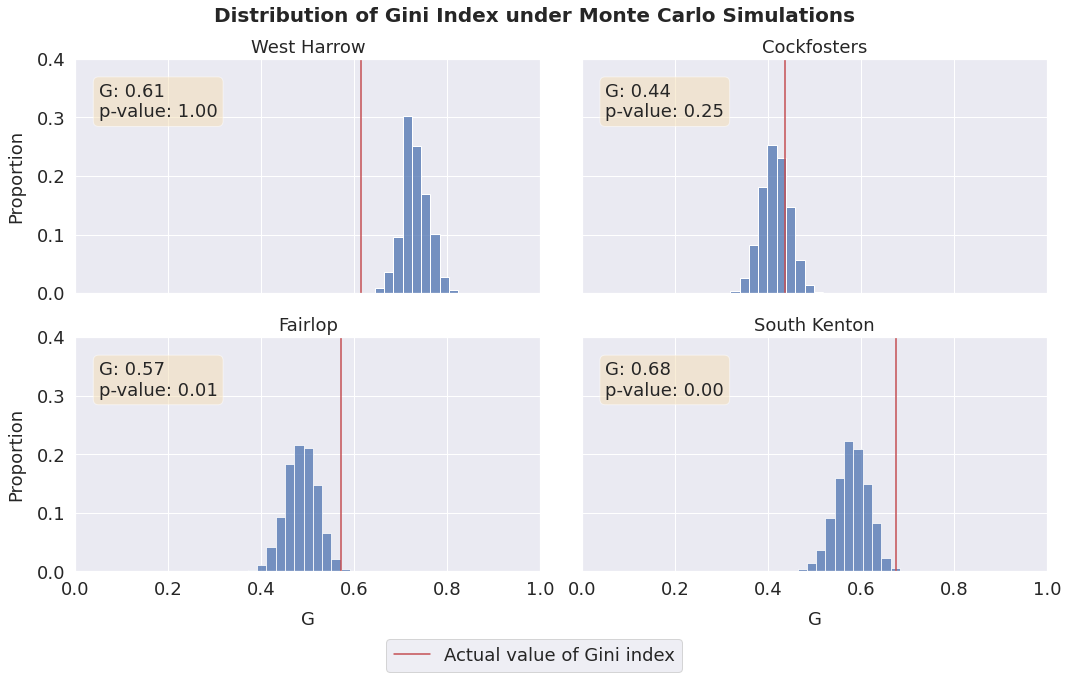

In [20]:
# Number of stations to plot
n_stn = 4

# Column headings
col_head = 'StationName'

# Stations of interest
stn_interest = p_gini.iloc[0:n_stn]['StationName']

# Start plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 9),
                       sharex='col', sharey='row')

for n in range(n_stn):

    # Get x and y axis of axes
    y = divmod(n, 2)[0]
    x = divmod(n, 2)[1]

    # Get station name
    stn = stn_interest.iloc[n]

    # Get simulation results
    sim_val = df_sim.loc[stn, :]

    # Plot histogram
    sns.histplot(sim_val, binwidth=0.02, stat='probability', ax=ax[y,x])
    ax[y, x].set_title(stn, size=18)
    ax[y, x].set(xlim=[0,1], ylim =[0, 0.4], yticks = np.arange(0, 0.5, 0.1))
    ax[y, x].tick_params(labelsize=18);
    ax[y, x].set_xlabel('G', size=18, labelpad=12)
    ax[y, x].set_ylabel('Proportion', size=18, labelpad=12)

    # Add actual gini
    stn_gini_plot = stn_conc_throughput.loc[stn_conc_throughput['StationName'] == stn,'gini'].values[0]
    act_gini = ax[y, x].axvline(stn_gini_plot, color=col_pal[3])

    # Get p-value
    p_val = p_gini.loc[p_gini['StationName'] == stn, 'p_value'].values[0]

    # Add textbox
    textstr = '\n'.join((r"G: "+"{:.2f}".format(stn_gini_plot),
                         "p-value: "+\
                         "{:.2f}".format(p_val)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[y, x].text(0.05, 0.9, textstr, transform=ax[y,x].transAxes, fontsize=18,
                  verticalalignment='top', bbox=props)

fig.suptitle(r'Distribution of Gini Index under Monte Carlo Simulations',
             fontsize=20, weight='bold')

fig.legend([act_gini],
           ["Actual value of Gini index"],
           loc='lower center', fontsize=18, 
           bbox_to_anchor=(0.5, -0.06))

fig.tight_layout()

#fig.savefig('outputs/figures/significance_test/mc_gini.png', bbox_inches="tight")

# Permutation Tests on Gamma

Here, I perform permuation tests (sampling without replacement) to check whether the influence of temporal dependencies on temporal concentration is significant.

Permutation tests are used for hypothesis testing. In this case, null hypothesis is that temporal dependencies has no influence on temporal concentration; in other words, temporal dependencies is random. Significance level is set at 5%, hence if p-value is greater than 5%, there is no evidence that temporal dependency is random.

## Functions for scalability

In [21]:
# Create function to perform one run of permutation test

def perm_gamma(df_ts, df_conc, n_sim, n_nb, wt_mtd):

    '''
    Perform one run of permutation tests to test significance of temporal concentration

    :param df_ts: the df of time series data
    :param df_conc: the df of concentration data
    :param n_sim: number of simulations in a run
    :param n_nb: number of neighbours for generating temporal weight matrix
    :param wt_mtd: weight assignment method for generating temporal weight matrix
    :return df_sim: df of stations and gamma for each simulation
    :return df_p: df of stations and its p-value
    '''

    df_func = df_ts.copy()

    # Create list to hold p-value
    p_list = []

    # Columns headers
    col_head = ['sim_' + str(n) for n in range(n_sim)]

    # For each station
    for stn in df_func.index:

        # Create list to hold gamma values
        gamma_perm = []

        # Get time series of station
        ts_stn = df_func.loc[df_func.index == stn].T
        ts_stn.columns = ['Y']
        
        # Get Gini and Gamma of station
        G = df_conc.loc[df_conc['StationName'] == stn, 'gini'].values[0]
        gamma = df_conc.loc[df_conc['StationName'] == stn, 'gamma'].values[0]

        # Compute Gini
        #G = gini(ts_stn, 'Y')

        # Get weight matrix if first station
        # Otherwise, can use the same matrix
        if stn == df_func.index[0]:
            wt_matrix = temporal_wt_matrix(ts_stn.copy(),
                                           n_nb,
                                           wt_mtd=wt_mtd)

        # Copy time series of station for permutation
        ts_stn_perm = ts_stn.copy()

        # Start simulation
        for run in range(n_sim):

            # Permutate journeys
            ts_stn_perm['Y'] = random.permutation(ts_stn['Y'])

            # Compute temporal lag value
            ts_stn_perm['WY'] = temporal_lagged(ts_stn_perm.copy(), wt_matrix)

            # Compute temporally re-ranked Gini
            G_T_perm = gini(ts_stn_perm, 'WY')

            # Compute gamma
            gamma_perm.append(G_T_perm/G)

        # Create/append dataframe to hold simulation results
        df_temp = pd.DataFrame([gamma_perm], columns=col_head, index=[stn])
        if stn == df_func.index[0]:
            df_sim = df_temp.copy()
        else:
            df_sim = pd.concat([df_sim, df_temp])

        # Compute p-value
        p, _ = compute_p(gamma_perm, gamma)
        p_list.append(p)

    # Create dataframe of p-values
    df_p = pd.DataFrame(zip(df_func.index, p_list),
                        columns=[df_func.index.name, 'p-value'])

    return df_sim, df_p

## Run Simulations

In [22]:
# Set up parameters
n_sim_perm = 500
n_run_perm = 20
offset_perm = 0

In [23]:
# Note: All the simulation results reported in the dissertation have been uploaded on the output folders

# Run simulations
for run in range(offset_perm, n_run_perm+offset_perm):

    print(f'Run {run}')
    #df_sim_run, df_p_run = perm_gamma(df_ts=stn_ts_throughput,
    #                                  df_conc=stn_conc_throughput,
    #                                  n_sim=n_sim_perm,
    #                                  n_nb=h,
    #                                  wt_mtd=wt_mtd)
    #df_sim_run.to_csv('outputs/sig_test/perm_gamma/sim_'+str(run)+'.csv')
    #df_p_run.to_csv('outputs/sig_test/perm_gamma/p_'+str(run)+'.csv', index=False)
    
print('Done!')

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Done!


## Inspect P-Values from Simulations

In [24]:
# Retrieve all gamma values from simulations
for run in range(n_run_perm):
    df_temp = pd.read_csv('outputs/sig_test/perm_gamma/sim_'+str(run)+'.csv')
    df_temp.rename(columns={'Unnamed: 0': 'StationName'}, inplace=True)
    df_temp.set_index('StationName', inplace=True)
    if run == 0:
        df_sim = df_temp.copy()
    else:
        df_sim = pd.concat([df_sim, df_temp], axis=1)

In [25]:
# Compute p-value for stations
p_list = []
rt_list = []

# For each station
for stn in stn_name:
    # Get observed gamma value
    stn_gamma = stn_conc_throughput.loc[stn_conc_throughput['StationName'] == stn,'gamma'].values[0]
    # Compute p-value
    p, rt = compute_p(df_sim.loc[stn, :].tolist(), stn_gamma)
    p_list.append(p)
    rt_list.append(rt)

# Create dataframe
p_gamma = pd.DataFrame(zip(stn_name, p_list, rt_list), columns=['StationName', 'p_value', 'rt'])

# Merge gamma data
p_gamma = p_gamma.merge(stn_conc_throughput[['StationName', 'gamma']], on='StationName')

In [26]:
# Rank stations by their p-value
p_gamma.sort_values(by=['p_value', 'rt', 'gamma'],
                    ascending=[False, False, True], inplace=True)

In [27]:
p_gamma.head(10)

,StationName,p_value,rt,gamma
186,Roding Valley,0.014699,146,0.555582
47,Chorleywood,0.001500,14,0.573085
152,North Ealing,0.001000,9,0.589653
145,Moor Park,0.000800,7,0.606301
40,Chalfont & Latimer,0.000200,1,0.630035
200,South Kenton,0.000100,0,0.638606
44,Chesham,0.000100,0,0.647265
116,Ickenham,0.000100,0,0.658684
231,Upminster Bridge,0.000100,0,0.670175
55,Croxley,0.000100,0,0.689535


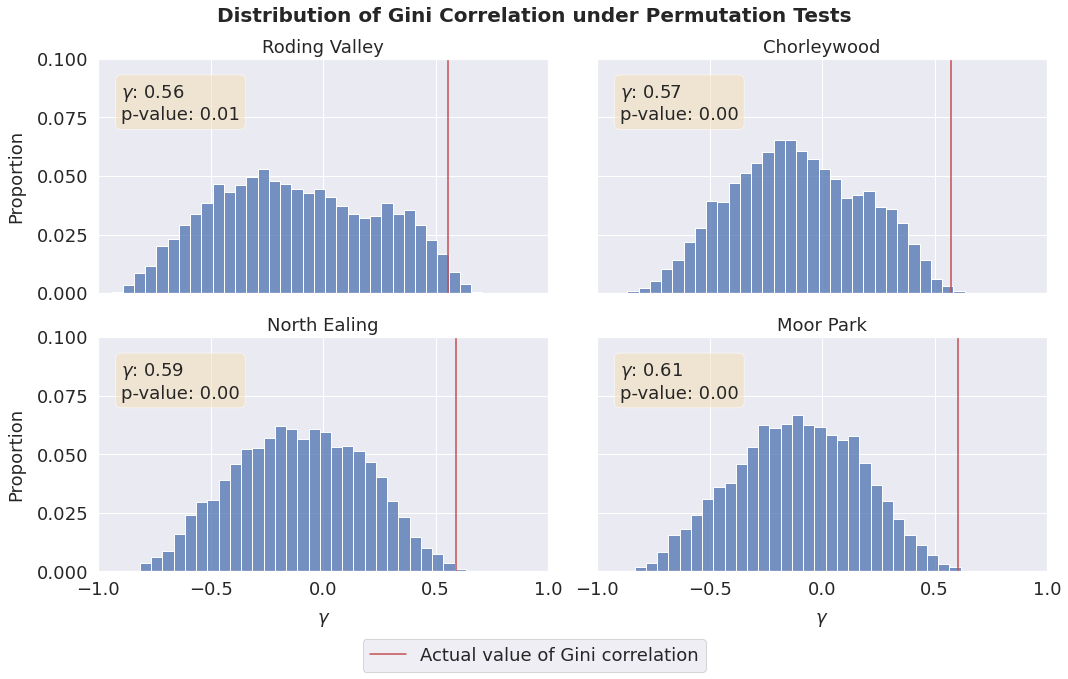

In [28]:
# Number of stations to plot
n_stn = 4

# Column headings
col_head = 'StationName'
    
# Stations of interest
stn_interest = p_gamma.iloc[0:n_stn]['StationName']

# Start plotting
fig, ax = plt.subplots(2, 2, figsize=(15,9), 
                       sharex='col', sharey='row')
    
for n in range(n_stn):
    
    # Get x and y axis of axes
    y = divmod(n, 2)[0]
    x = divmod(n, 2)[1]
    
    # Get station name
    stn = stn_interest.iloc[n]
    
    # Get simulation results
    sim_val = df_sim.loc[stn, :]
    
    # Plot histogram
    sns.histplot(sim_val, binwidth=0.05, stat='probability', ax=ax[y,x])
    ax[y, x].set_title(stn, size=18)
    ax[y, x].set(xlim=[-1, 1], xticks=[-1, -0.5, 0, 0.5, 1],
                 ylim =[0, 0.1], yticks = [0, 0.025, 0.05, 0.075, 0.1])
    ax[y, x].tick_params(labelsize=18);
    ax[y, x].set_xlabel(r'$\gamma$', size=18, labelpad=12)
    ax[y, x].set_ylabel('Proportion', size=18, labelpad=12)
    
    # Add actual gamma
    stn_gamma_plot = stn_conc_throughput.loc[stn_conc_throughput['StationName'] == stn,'gamma'].values[0]
    act_gamma = ax[y, x].axvline(stn_gamma_plot, color=col_pal[3])
        
    # Get p-value
    p_val = p_gamma.loc[p_gamma['StationName'] == stn, 'p_value'].values[0]
    
    # Add textbox
    textstr = '\n'.join((r"$\gamma$: "+"{:.2f}".format(stn_gamma_plot),
                         "p-value: "+\
                         "{:.2f}".format(p_val)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[y, x].text(0.05, 0.9, textstr, transform=ax[y,x].transAxes, fontsize=18,
                  verticalalignment='top', bbox=props)
    
fig.suptitle('Distribution of Gini Correlation under Permutation Tests',
             fontsize=20, weight='bold')
fig.legend([act_gamma],
           ["Actual value of Gini correlation"],
           loc='lower center', fontsize=18, 
           bbox_to_anchor=(0.5, -0.06))
fig.tight_layout()

#fig.savefig('outputs/figures/significance_test/perm_test_gamma.png',
#            bbox_inches="tight")